In [1]:
import os
import numpy as np
np.random.seed(69)
import pandas as pd
import random
import pickle as pkl
import matplotlib.pyplot as plt
import matplotlib.image as img
import seaborn as sns
sns.set()
import tensorflow as tf
from tqdm.notebook import tqdm
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,concatenate, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, ZeroPadding2D, LeakyReLU, ReLU, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import load_model
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import time

# 1. Create Train/Val/Test Sets

In [2]:
X = np.load("../dataset/paperX.npy")

In [3]:
dnnx = np.load("../dataset/paperdnnx.npy")

In [4]:
objlist = np.load("../dataset/paperobjlist.npy")

In [5]:
y = np.load("../dataset/papery.npy", allow_pickle=True)

### Delete all QSOs

In [6]:
idx_drop = np.where(y=="QSO")[0]

In [7]:
X = np.delete(X,idx_drop,axis=0)
dnnx = np.delete(dnnx,idx_drop,axis=0)
y = np.delete(y,idx_drop,axis=0)
objlist = np.delete(objlist,idx_drop,axis=0)

In [8]:
y, label_strings = pd.factorize(y,sort=True)
y = to_categorical(y)
print(label_strings)

['GALAXY' 'STAR']


In [9]:
zipX = list(zip(X, dnnx))
zipy = list(zip(y, objlist))

zipX_train, zipX_test, zipy_train, zipy_test = train_test_split(zipX, zipy, test_size = 0.125,random_state=42)
zipX_train, zipX_val, zipy_train, zipy_val = train_test_split(zipX_train, zipy_train, test_size = 0.1428, random_state=42)

X_train, dnnx_train = zip(*zipX_train)
X_val, dnnx_val = zip(*zipX_val)
X_test, dnnx_test = zip(*zipX_test)

y_train, objlist_train = zip(*zipy_train)
y_val, objlist_val = zip(*zipy_val)
y_test, objlist_test = zip(*zipy_test)

X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)

dnnx_train = np.array(dnnx_train)
dnnx_val = np.array(dnnx_val)
dnnx_test = np.array(dnnx_test)

y_train = np.array(y_train)
objlist_train = np.array(objlist_train)
y_val = np.array(y_val)
objlist_val = np.array(objlist_val)
y_test = np.array(y_test)
objlist_test = np.array(objlist_test)


del(zipX,zipX_test,zipX_train,zipX_val, X, zipy, zipy_test, zipy_train, zipy_val, objlist)

In [10]:
print(dnnx_train.shape)
print(dnnx_val.shape)
print(dnnx_test.shape)

(120007, 24)
(19992, 24)
(20000, 24)


In [11]:
def get_metrics(y_pred, y_test, labels, to_print=True):
    correct_labels = np.where(y_pred==y_test)[0]
    accuracy = metrics.accuracy_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred,average='macro')
    recall = metrics.recall_score(y_test, y_pred,average='macro')
    f1score = metrics.f1_score(y_test, y_pred,average='macro')
    # rocscore = metrics.roc_auc_score(y_test, y_pred,average='micro',multi_class="ovo")
    confusion_matrix = metrics.confusion_matrix(y_test, y_pred)  
    classification_report = metrics.classification_report(y_test, y_pred)

    if to_print:
        print("Identified {} correct labels out of {} labels".format(len(correct_labels), y_test.shape[0]))
        print("Accuracy:",accuracy)
        print("Precision:",precision)
        print("Recall:",recall)
        print("F1 Score:",f1score)
        # print("ROC AUC Score:",rocscore)
        print(f"Labels are: {labels}")
        print("Confusion Matrix:\n", confusion_matrix)
        print("Classification_Report:\n", classification_report)

    return (correct_labels, accuracy, precision, recall, confusion_matrix, classification_report)

In [12]:
def plot_model_change(history,fname="output/time.pdf"):
    # summarize history for accuracy
    plt.plot(history.history['accuracy'],label="Training Acc")
    plt.plot(history.history['val_accuracy'],label="Val Acc")
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'],label="Training Loss")
    plt.plot(history.history['val_loss'],label="Val Loss")
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.savefig(fname)
    plt.show()

# 2. Train a DNN Classifier

In [13]:
model = Sequential()

model.add(Dense(1024, activation="sigmoid", input_dim=dnnx_train.shape[1]))
model.add(Dropout(0.25))
model.add(Dense(256, activation="sigmoid"))
model.add(Dropout(0.25))
model.add(Dense(128, activation="sigmoid"))
model.add(Dropout(0.25))
model.add(Dense(64, activation="sigmoid"))
model.add(Dropout(0.25))
model.add(Dense(32, activation="sigmoid"))
model.add(Dropout(0.25))

model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', verbose=0, patience=100, restore_best_weights=True)
cb = [es]
history = model.fit(dnnx_train, y_train,
                    batch_size=2048,
                    epochs = 4000,
                    validation_data = (dnnx_val,y_val),
                    callbacks = cb,
                    verbose = 2)

Epoch 1/4000
59/59 - 1s - loss: 0.7020 - accuracy: 0.5260 - val_loss: 0.5947 - val_accuracy: 0.8831
Epoch 2/4000
59/59 - 0s - loss: 0.3416 - accuracy: 0.8823 - val_loss: 0.1939 - val_accuracy: 0.9340
Epoch 3/4000
59/59 - 0s - loss: 0.2120 - accuracy: 0.9276 - val_loss: 0.1658 - val_accuracy: 0.9435
Epoch 4/4000
59/59 - 0s - loss: 0.1859 - accuracy: 0.9366 - val_loss: 0.1577 - val_accuracy: 0.9461
Epoch 5/4000
59/59 - 0s - loss: 0.1748 - accuracy: 0.9408 - val_loss: 0.1638 - val_accuracy: 0.9430
Epoch 6/4000
59/59 - 0s - loss: 0.1710 - accuracy: 0.9417 - val_loss: 0.1479 - val_accuracy: 0.9500
Epoch 7/4000
59/59 - 0s - loss: 0.1650 - accuracy: 0.9431 - val_loss: 0.1404 - val_accuracy: 0.9536
Epoch 8/4000
59/59 - 0s - loss: 0.1579 - accuracy: 0.9466 - val_loss: 0.1378 - val_accuracy: 0.9546
Epoch 9/4000
59/59 - 0s - loss: 0.1539 - accuracy: 0.9475 - val_loss: 0.1359 - val_accuracy: 0.9554
Epoch 10/4000
59/59 - 0s - loss: 0.1505 - accuracy: 0.9491 - val_loss: 0.1394 - val_accuracy: 0.9523

In [14]:
model.save("output/DNNClassifier.h5")

In [15]:
plot_model(model,"output/DNNMod.pdf",show_shapes=True)

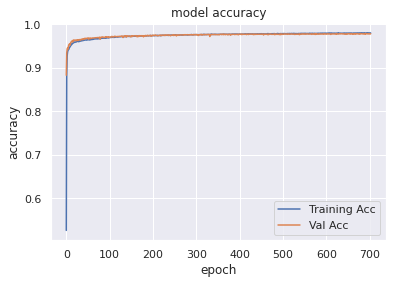

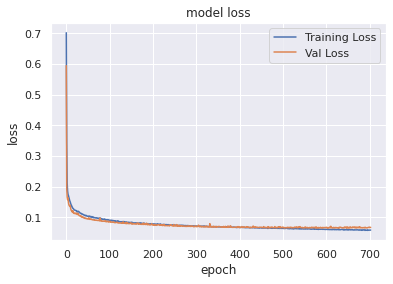

In [16]:
plot_model_change(history,fname="output/DNNTraining.pdf")

In [17]:
preds_test = model.predict(dnnx_test,batch_size=2048, verbose = 0)
print(get_metrics(preds_test.argmax(axis=1), y_test.argmax(axis=1),label_strings))

Identified 19570 correct labels out of 20000 labels
Accuracy: 0.9785
Precision: 0.9784968703298599
Recall: 0.9785082588633196
F1 Score: 0.9784997366217737
Labels are: ['GALAXY' 'STAR']
Confusion Matrix:
 [[9750  198]
 [ 232 9820]]
Classification_Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      9948
           1       0.98      0.98      0.98     10052

    accuracy                           0.98     20000
   macro avg       0.98      0.98      0.98     20000
weighted avg       0.98      0.98      0.98     20000

(array([    0,     1,     2, ..., 19997, 19998, 19999]), 0.9785, 0.9784968703298599, 0.9785082588633196, array([[9750,  198],
       [ 232, 9820]]), '              precision    recall  f1-score   support\n\n           0       0.98      0.98      0.98      9948\n           1       0.98      0.98      0.98     10052\n\n    accuracy                           0.98     20000\n   macro avg       0.98      0.98      0.98 

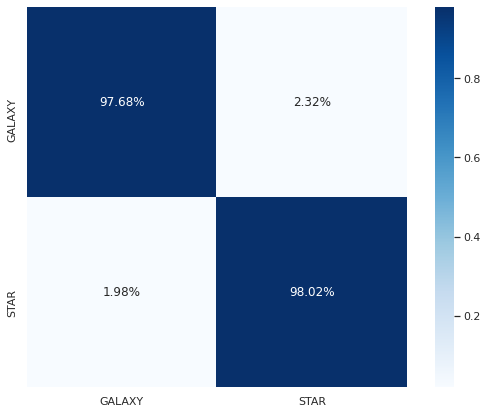

In [18]:
cm = metrics.confusion_matrix(preds_test.argmax(axis=1), y_test.argmax(axis=1),normalize='true')
df_cm = pd.DataFrame(cm, index = label_strings,columns = label_strings)
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True,cmap="Blues",square=True,fmt='.2%')
plt.savefig("output/dnn_cm.pdf")

In [19]:
del(dnnx_train)

# 3. Train a CNN Classifier

In [20]:
inp_layer = tf.keras.Input(shape=X_train.shape[1:])

mod = Conv2D(filters=64, kernel_size=(5,5), padding='same')(inp_layer)
mod = ReLU()(mod)


# mod = AveragePooling2D(pool_size=(2, 2), strides=2)(mod)

c1 = Conv2D(filters=48, kernel_size=(1,1), padding='same')(mod)
c1 = ReLU()(c1)
c2 = Conv2D(filters=48, kernel_size=(1,1), padding='same')(mod)
c2 = ReLU()(c2)
c3 = Conv2D(filters=48, kernel_size=(1,1), padding='same')(mod)
c3 = ReLU()(c3)
c4 = Conv2D(filters=64, kernel_size=(1,1), padding='same')(c1)
c4 = ReLU()(c4)
c5 = Conv2D(filters=64, kernel_size=(3,3), padding='same')(c1)
c5 = ReLU()(c5)
c6 = Conv2D(filters=64, kernel_size=(5,5), padding='same')(c2)
c6 = ReLU()(c6)
p1 = AveragePooling2D(pool_size=(1, 1))(c3)
mod = concatenate([c4,c5,c6,p1])

c7 = Conv2D(filters=64, kernel_size=(1,1), padding='same')(mod)
c7 = ReLU()(c7)
c8 = Conv2D(filters=64, kernel_size=(1,1), padding='same')(mod)
c8 = ReLU()(c8)
c9 = Conv2D(filters=64, kernel_size=(1,1), padding='same')(mod)
c9 = ReLU()(c9)
c10 = Conv2D(filters=92, kernel_size=(1,1), padding='same')(c7)
c10 = ReLU()(c10)
c11 = Conv2D(filters=92, kernel_size=(3,3), padding='same')(c7)
c11 = ReLU()(c11)
c12 = Conv2D(filters=92, kernel_size=(5,5), padding='same')(c8)
c12 = ReLU()(c12)
p2 = AveragePooling2D(pool_size=(1, 1))(c9)
mod = concatenate([c10,c11,c12,p2])
mod = AveragePooling2D(pool_size=(2, 2))(mod)

c13 = Conv2D(filters=92, kernel_size=(1,1), padding='same')(mod)
c13 = ReLU()(c13)
c14 = Conv2D(filters=92, kernel_size=(1,1), padding='same')(mod)
c14 = ReLU()(c14)
c15 = Conv2D(filters=92, kernel_size=(1,1), padding='same')(mod)
c15 = ReLU()(c15)
c16 = Conv2D(filters=128, kernel_size=(1,1), padding='same')(c13)
c16 = ReLU()(c16)
c17 = Conv2D(filters=128, kernel_size=(3,3), padding='same')(c13)
c17 = ReLU()(c17)
c18 = Conv2D(filters=128, kernel_size=(5,5), padding='same')(c14)
c18 = ReLU()(c18)
p3 = AveragePooling2D(pool_size=(1, 1))(c15)
mod = concatenate([c16,c17,c18,p3])

c19 = Conv2D(filters=92, kernel_size=(1,1), padding='same')(mod)
c19 = ReLU()(c19)
c20 = Conv2D(filters=92, kernel_size=(1,1), padding='same')(mod)
c20 = ReLU()(c20)
c21 = Conv2D(filters=92, kernel_size=(1,1), padding='same')(mod)
c21 = ReLU()(c21)
c22 = Conv2D(filters=128, kernel_size=(1,1), padding='same')(c19)
c22 = ReLU()(c22)
c23 = Conv2D(filters=128, kernel_size=(3,3), padding='same')(c19)
c23 = ReLU()(c23)
c24 = Conv2D(filters=128, kernel_size=(5,5), padding='same')(c20)
c24 = ReLU()(c24)
p4 = AveragePooling2D(pool_size=(1, 1))(c21)
mod = concatenate([c22,c23,c24,p4])
mod = AveragePooling2D(pool_size=(2, 2))(mod)

c25 = Conv2D(filters=92, kernel_size=(1,1), padding='same')(mod)
c25 = ReLU()(c25)
c26 = Conv2D(filters=92, kernel_size=(1,1), padding='same')(mod)
c26 = ReLU()(c26)
c27 = Conv2D(filters=128, kernel_size=(1,1), padding='same')(mod)
c27 = ReLU()(c27)
c28 = Conv2D(filters=128, kernel_size=(3,3), padding='same')(c25)
c28 = ReLU()(c28)
p5 = AveragePooling2D(pool_size=(1, 1))(c26)
mod = concatenate([c27,c28,p5])
mod = Flatten()(mod)    #Check
mod = Dense(1024)(mod)
mod = Dense(1024)(mod)
out_layer = Dense(2, activation="softmax") (mod)
model = tf.keras.Model(inputs=inp_layer, outputs=out_layer)

model.compile(optimizer = 'adam' , loss = "categorical_crossentropy", metrics=["accuracy"])


In [21]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=180,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)
datagen.fit(X_train)


es = EarlyStopping(monitor='val_loss', verbose=1, patience=30, restore_best_weights=True)

cb = [es]


/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:947: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (120007, 32, 32, 5) (5 channels).
  ' channels).')


In [22]:
history = model.fit(datagen.flow(X_train,y_train, batch_size=512),
                              epochs = 300, validation_data = (X_val,y_val),
                              callbacks = cb,
                              verbose = 1)

/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/numpy_array_iterator.py:136: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (120007, 32, 32, 5) (5 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


Epoch 1/300
235/235 [==============================] - 116s 493ms/step - loss: 0.2262 - accuracy: 0.9174 - val_loss: 0.1451 - val_accuracy: 0.9504
Epoch 2/300
235/235 [==============================] - 116s 495ms/step - loss: 0.1295 - accuracy: 0.9561 - val_loss: 0.1383 - val_accuracy: 0.9538
Epoch 3/300
235/235 [==============================] - 115s 489ms/step - loss: 0.1213 - accuracy: 0.9584 - val_loss: 0.1232 - val_accuracy: 0.9592
Epoch 4/300
235/235 [==============================] - 114s 486ms/step - loss: 0.1161 - accuracy: 0.9599 - val_loss: 0.1087 - val_accuracy: 0.9627
Epoch 5/300
235/235 [==============================] - 117s 499ms/step - loss: 0.1090 - accuracy: 0.9625 - val_loss: 0.1244 - val_accuracy: 0.9578
Epoch 6/300
235/235 [==============================] - 118s 504ms/step - loss: 0.1079 - accuracy: 0.9636 - val_loss: 0.1017 - val_accuracy: 0.9653
Epoch 7/300
235/235 [==============================] - 118s 502ms/step - loss: 0.1039 - accuracy: 0.9640 - val_loss: 0

In [23]:
model.save("output/CNNClassifier.h5")

In [24]:
plot_model(model,"output/CNNMod.pdf",show_shapes=True)

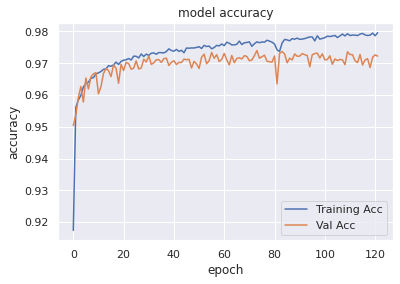

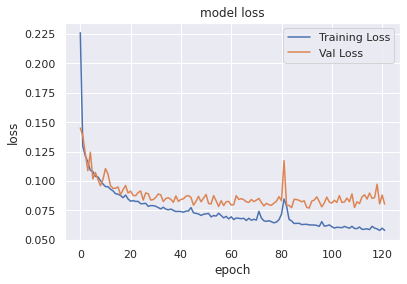

In [25]:
plot_model_change(history,fname="output/CNNTraining.pdf")

In [26]:
preds_test = model.predict(X_test,batch_size=1024, verbose = 0)
print(get_metrics(preds_test.argmax(axis=1), y_test.argmax(axis=1),label_strings))

Identified 19473 correct labels out of 20000 labels
Accuracy: 0.97365
Precision: 0.973709688894282
Recall: 0.9736256268369496
F1 Score: 0.9736474948649807
Labels are: ['GALAXY' 'STAR']
Confusion Matrix:
 [[9639  309]
 [ 218 9834]]
Classification_Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.97      9948
           1       0.97      0.98      0.97     10052

    accuracy                           0.97     20000
   macro avg       0.97      0.97      0.97     20000
weighted avg       0.97      0.97      0.97     20000

(array([    0,     1,     2, ..., 19997, 19998, 19999]), 0.97365, 0.973709688894282, 0.9736256268369496, array([[9639,  309],
       [ 218, 9834]]), '              precision    recall  f1-score   support\n\n           0       0.98      0.97      0.97      9948\n           1       0.97      0.98      0.97     10052\n\n    accuracy                           0.97     20000\n   macro avg       0.97      0.97      0.97 

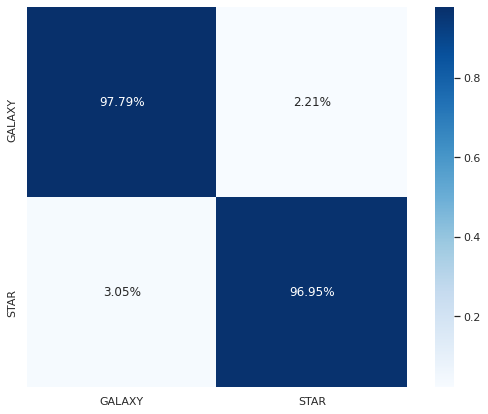

In [27]:
cm = metrics.confusion_matrix(preds_test.argmax(axis=1), y_test.argmax(axis=1),normalize='true')
df_cm = pd.DataFrame(cm, index = label_strings,columns = label_strings)
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True,cmap="Blues",square=True,fmt='.2%')
plt.savefig("output/cnn_cm.pdf")

In [28]:
del(X_train)

# 4. Train the Ensemble Classifier

In [29]:
cnnclassifier = load_model("output/CNNClassifier.h5")
dnnclassifier = load_model("output/DNNClassifier.h5")

In [30]:
def define_stacked_model(members):
    # update all layers in all models to not be trainable
    for i in range(len(members)):
        model = members[i]
        for layer in model.layers:
            # make not trainable
            layer.trainable = False
            # rename to avoid 'unique layer name' issue
            layer._name = 'ensemble_' + str(i+1) + '_' + layer.name
    # define multi-headed input
    ensemble_visible = [model.input for model in members]
    # concatenate merge output from each model
    ensemble_outputs = [model.output for model in members]
    merge = tf.keras.layers.concatenate(ensemble_outputs)
    hidden = Dense(10, activation='relu')(merge)
    output = Dense(2, activation='softmax')(hidden)
    model = tf.keras.Model(inputs=ensemble_visible, outputs=output)
    # plot graph of ensemble
    plot_model(model, show_shapes=True, to_file='model_graph.png')
    # compile
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [31]:
# define ensemble model
members = [cnnclassifier,dnnclassifier]
model = define_stacked_model(members)

In [32]:
filepath="output/EnsembleClassifier.h5"

checkpointcb = tf.keras.callbacks.ModelCheckpoint(filepath=filepath,monitor='loss',mode='min',save_best_only=True,verbose=1,save_weights_only=False)
cb = [checkpointcb]


In [33]:
history = model.fit([X_val, dnnx_val],
                            y_val, epochs=100,
                            batch_size=512,
                            callbacks=cb,
                            verbose=1)

Epoch 1/100
39/40 [============================>.] - ETA: 0s - loss: 0.5922 - accuracy: 0.4981
Epoch 00001: loss improved from inf to 0.59210, saving model to EnsembleClassifier.h5
40/40 [==============================] - 4s 109ms/step - loss: 0.5921 - accuracy: 0.4982
Epoch 2/100
39/40 [============================>.] - ETA: 0s - loss: 0.4843 - accuracy: 0.7572
Epoch 00002: loss improved from 0.59210 to 0.48416, saving model to EnsembleClassifier.h5
40/40 [==============================] - 4s 108ms/step - loss: 0.4842 - accuracy: 0.7575
Epoch 3/100
39/40 [============================>.] - ETA: 0s - loss: 0.3703 - accuracy: 0.9717
Epoch 00003: loss improved from 0.48416 to 0.37024, saving model to EnsembleClassifier.h5
40/40 [==============================] - 4s 107ms/step - loss: 0.3702 - accuracy: 0.9717
Epoch 4/100
39/40 [============================>.] - ETA: 0s - loss: 0.2738 - accuracy: 0.9763
Epoch 00004: loss improved from 0.37024 to 0.27374, saving model to EnsembleClassifier.

In [34]:
del(X_val, dnnx_val)

In [35]:
model = load_model("output/EnsembleClassifier.h5")

In [36]:
model.evaluate([X_test, dnnx_test],y_test)

625/625 [==============================] - 7s 10ms/step - loss: 0.0594 - accuracy: 0.9813


[0.05936643108725548, 0.9812999963760376]

In [37]:
plot_model(model,"output/EnsembleMod.pdf",show_shapes=True)

In [38]:
preds_test = model.predict([X_test, dnnx_test],batch_size=512, verbose = 0)
print(get_metrics(preds_test.argmax(axis=1), y_test.argmax(axis=1),label_strings))

Identified 19626 correct labels out of 20000 labels
Accuracy: 0.9813
Precision: 0.9813071163776929
Recall: 0.9812937741836538
F1 Score: 0.9812992577675408
Labels are: ['GALAXY' 'STAR']
Confusion Matrix:
 [[9750  198]
 [ 176 9876]]
Classification_Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      9948
           1       0.98      0.98      0.98     10052

    accuracy                           0.98     20000
   macro avg       0.98      0.98      0.98     20000
weighted avg       0.98      0.98      0.98     20000

(array([    0,     1,     2, ..., 19997, 19998, 19999]), 0.9813, 0.9813071163776929, 0.9812937741836538, array([[9750,  198],
       [ 176, 9876]]), '              precision    recall  f1-score   support\n\n           0       0.98      0.98      0.98      9948\n           1       0.98      0.98      0.98     10052\n\n    accuracy                           0.98     20000\n   macro avg       0.98      0.98      0.98 

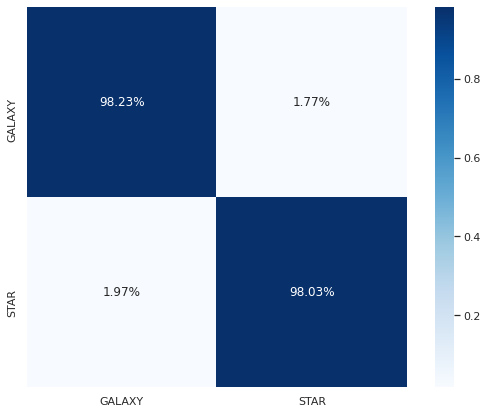

In [39]:
cm = metrics.confusion_matrix(preds_test.argmax(axis=1), y_test.argmax(axis=1),normalize='true')
df_cm = pd.DataFrame(cm, index = label_strings,columns = label_strings)
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True,cmap="Blues",square=True,fmt='.2%')
plt.savefig("output/ensemble_cm.pdf")

# 5. Analyse Results

In [40]:
model = load_model("output/EnsembleClassifier.h5")

In [41]:
preds_train = model.predict([X_train, dnnx_train],batch_size=512, verbose = 0)
print(get_metrics(preds_train.argmax(axis=1), y_train.argmax(axis=1),label_strings))

Identified 118311 correct labels out of 120007 labels
Accuracy: 0.9858674910630213
Precision: 0.9858714998170801
Recall: 0.9858701044460592
F1 Score: 0.9858674888953078
Labels are: ['GALAXY' 'STAR']
Confusion Matrix:
 [[59132   958]
 [  738 59179]]
Classification_Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99     60090
           1       0.98      0.99      0.99     59917

    accuracy                           0.99    120007
   macro avg       0.99      0.99      0.99    120007
weighted avg       0.99      0.99      0.99    120007

(array([     0,      1,      2, ..., 120004, 120005, 120006]), 0.9858674910630213, 0.9858714998170801, 0.9858701044460592, array([[59132,   958],
       [  738, 59179]]), '              precision    recall  f1-score   support\n\n           0       0.99      0.98      0.99     60090\n           1       0.98      0.99      0.99     59917\n\n    accuracy                           0.99    120007\n   m

In [42]:
del(dnnx_train,X_train)

In [43]:
preds_val = model.predict([X_val, dnnx_val],batch_size=512, verbose = 0)
print(get_metrics(preds_val.argmax(axis=1), y_val.argmax(axis=1),label_strings))

Identified 19626 correct labels out of 19992 labels
Accuracy: 0.9816926770708283
Precision: 0.9817055824835842
Recall: 0.9816857972190636
F1 Score: 0.98169214278637
Labels are: ['GALAXY' 'STAR']
Confusion Matrix:
 [[9759  202]
 [ 164 9867]]
Classification_Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      9961
           1       0.98      0.98      0.98     10031

    accuracy                           0.98     19992
   macro avg       0.98      0.98      0.98     19992
weighted avg       0.98      0.98      0.98     19992

(array([    0,     1,     2, ..., 19989, 19990, 19991]), 0.9816926770708283, 0.9817055824835842, 0.9816857972190636, array([[9759,  202],
       [ 164, 9867]]), '              precision    recall  f1-score   support\n\n           0       0.98      0.98      0.98      9961\n           1       0.98      0.98      0.98     10031\n\n    accuracy                           0.98     19992\n   macro avg       0.9

In [44]:
del(X_val, dnnx_val)

In [45]:
preds_test = model.predict([X_test, dnnx_test],batch_size=512, verbose = 0)
print(get_metrics(preds_test.argmax(axis=1), y_test.argmax(axis=1),label_strings))

Identified 19626 correct labels out of 20000 labels
Accuracy: 0.9813
Precision: 0.9813071163776929
Recall: 0.9812937741836538
F1 Score: 0.9812992577675408
Labels are: ['GALAXY' 'STAR']
Confusion Matrix:
 [[9750  198]
 [ 176 9876]]
Classification_Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      9948
           1       0.98      0.98      0.98     10052

    accuracy                           0.98     20000
   macro avg       0.98      0.98      0.98     20000
weighted avg       0.98      0.98      0.98     20000

(array([    0,     1,     2, ..., 19997, 19998, 19999]), 0.9813, 0.9813071163776929, 0.9812937741836538, array([[9750,  198],
       [ 176, 9876]]), '              precision    recall  f1-score   support\n\n           0       0.98      0.98      0.98      9948\n           1       0.98      0.98      0.98     10052\n\n    accuracy                           0.98     20000\n   macro avg       0.98      0.98      0.98 

In [46]:
df = pd.read_csv("../dataset/paperDF.csv",index_col=0)

In [47]:
df = df[df["class"]!="QSO"].reset_index()
df = df.set_index(["objid"])

In [48]:
df.loc[objlist_train, ["set"]] = "TRAIN"
df.loc[objlist_val, ["set"]] = "VALIDATION"
df.loc[objlist_test, ["set"]] = "TEST"

In [49]:
df.loc[objlist_train, ["pred_class"]] = label_strings[preds_train.argmax(axis=1)]
df.loc[objlist_val, ["pred_class"]] = label_strings[preds_val.argmax(axis=1)]
df.loc[objlist_test, ["pred_class"]] = label_strings[preds_test.argmax(axis=1)]

In [50]:
pgal_train = preds_train[:,np.where(label_strings=="GALAXY")[0][0]]
pstar_train = preds_train[:,np.where(label_strings=="STAR")[0][0]]

pgal_val = preds_val[:,np.where(label_strings=="GALAXY")[0][0]]
pstar_val = preds_val[:,np.where(label_strings=="STAR")[0][0]]

pgal_test = preds_test[:,np.where(label_strings=="GALAXY")[0][0]]
pstar_test = preds_test[:,np.where(label_strings=="STAR")[0][0]]

In [51]:
df.loc[objlist_train, ["prob_gal"]] = pgal_train
df.loc[objlist_train, ["prob_star"]] = pstar_train

df.loc[objlist_val, ["prob_gal"]] = pgal_val
df.loc[objlist_val, ["prob_star"]] = pstar_val

df.loc[objlist_test, ["prob_gal"]] = pgal_test
df.loc[objlist_test, ["prob_star"]] = pstar_test

In [52]:
df.to_csv("output/star_galaxy_results.csv")

In [53]:
df

,specobjid,class,run,rerun,camcol,field,ra,dec,redshift,dered_u,...,psffwhm_z,extinction_z,u_g,g_r,r_i,i_z,set,pred_class,prob_gal,prob_star
objid,,,,,,,,,,,,,,,,,,,,,
1237657770705092710,1.011112e+18,STAR,2863,301,3,97,136.281263,45.937524,0.000350,19.31773,...,1.088641,0.023224,1.885117,0.665094,0.237171,0.123188,TRAIN,STAR,0.006106,0.993893
1237663233911423592,2.117919e+18,STAR,4135,301,3,218,357.504185,37.612360,0.000047,22.37974,...,0.812222,0.196325,2.640505,1.551123,0.709044,0.456682,TRAIN,STAR,0.006965,0.993035
1237662662146261041,1.866813e+18,STAR,4002,301,2,254,245.783625,21.675879,0.000023,24.44682,...,0.907692,0.055966,3.161671,1.725903,0.903172,0.069504,TRAIN,STAR,0.138404,0.861596
1237662696494071894,4.362957e+18,STAR,4010,301,2,72,223.540963,30.205048,0.004153,20.70732,...,1.136051,0.028292,1.148272,0.063143,0.038881,0.162985,TRAIN,STAR,0.006124,0.993876
1237646647297376672,8.974698e+17,STAR,273,301,4,413,71.789168,0.107176,0.000092,20.92369,...,1.088172,0.076531,1.013275,0.341276,0.076004,0.003963,TRAIN,STAR,0.006543,0.993457
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1237655472895754596,1.207874e+19,GALAXY,2328,301,3,69,250.369864,38.025395,0.030712,22.70895,...,1.115590,0.025494,0.744795,0.371923,-0.501959,0.358709,TRAIN,GALAXY,0.994462,0.005538
1237662531140256443,6.145412e+18,GALAXY,3971,301,6,109,215.191993,13.891245,0.567631,22.19107,...,1.346293,0.027273,0.111118,1.441298,0.997200,0.340303,TRAIN,GALAXY,0.995014,0.004986
1237663530252828897,4.118603e+18,GALAXY,4204,301,3,45,113.453531,40.363800,0.387790,23.78991,...,1.075638,0.062853,1.892675,1.703798,0.794130,0.319218,TEST,GALAXY,0.995010,0.004990


In [54]:
subdf = df[(df["dered_r"]+df["extinction_r"])>22.5]

In [55]:
subdf[(subdf["class"]=="STAR") & (subdf["set"]=="TEST")]["pred_class"].value_counts()

STAR    6
Name: pred_class, dtype: int64

In [56]:
subdf

,specobjid,class,run,rerun,camcol,field,ra,dec,redshift,dered_u,...,psffwhm_z,extinction_z,u_g,g_r,r_i,i_z,set,pred_class,prob_gal,prob_star
objid,,,,,,,,,,,,,,,,,,,,,
1237661066552083989,1.977233e+18,STAR,3630,301,6,43,122.742998,7.016514,0.000134,22.83868,...,1.214127,0.027020,-1.772738,2.057627,2.741682,1.567526,TRAIN,STAR,0.006011,0.993989
1237657190369264352,8.853114e+18,STAR,2728,301,2,427,2.091510,-0.517745,0.000106,24.95545,...,0.944354,0.052480,0.467239,2.075537,1.707586,0.899160,TRAIN,STAR,0.007208,0.992792
1237662224625566825,1.864596e+18,STAR,3900,301,3,698,240.597227,25.070219,0.000045,23.85450,...,0.808966,0.075021,-0.133892,1.151447,2.803328,1.721769,TRAIN,STAR,0.006009,0.993991
1237668349221404967,5.862757e+18,STAR,5326,301,3,278,241.691836,9.423995,0.000114,23.72850,...,1.325469,0.059649,-1.790113,3.071341,2.565027,1.846264,TRAIN,STAR,0.006019,0.993981
1237662618649232308,5.316738e+18,STAR,3992,301,1,94,235.309690,31.260651,0.000149,26.55423,...,1.134007,0.034724,2.599382,1.225565,2.685234,1.393661,VALIDATION,STAR,0.006003,0.993997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1237660961327678173,1.174790e+19,GALAXY,3606,301,2,78,135.662601,32.374407,0.831374,25.06951,...,1.178774,0.029742,1.774759,0.886816,0.787844,-0.097712,TEST,GALAXY,0.995018,0.004982
1237663785284468805,1.056888e+19,GALAXY,4263,301,6,319,30.423351,0.987627,0.738361,23.91744,...,1.397365,0.032070,1.051489,0.409035,1.170586,-0.097206,TRAIN,GALAXY,0.995036,0.004964
1237667322172997876,1.177821e+19,GALAXY,5087,301,2,59,159.076869,24.435216,0.957642,22.09585,...,1.113986,0.024162,-0.286564,-0.177673,0.749508,1.129305,TEST,GALAXY,0.994946,0.005054
